In [1]:
import tensorflow as tf
import numpy as np

import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from IPython import display

from baseline import DVBF
from world import PendulumFullObs

def sample_batch(X, U, batch_size):
    sample = np.random.rand(batch_size) * X.shape[1]
    sample = sample.astype(int)

    batch_x = X[:, sample]
    batch_u = U[:, sample]
    
    return batch_x, batch_u

In [2]:
# Get the dataset
world = PendulumFullObs()
X, U, R, S = world.get_data_set(episodes=500, steps=50)

[2017-09-03 11:40:07,397] Making new env: Pendulum-v0


('total loss at epoch: ', 0, ' : ', 496877.140625)


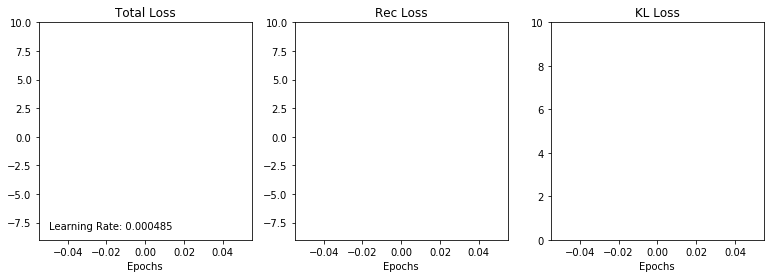

('total loss at epoch: ', 10, ' : ', 2248.7861328125)


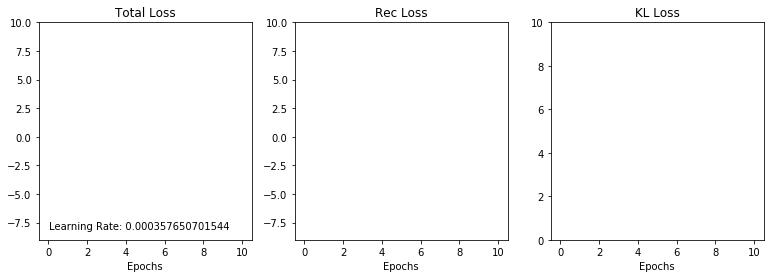

('total loss at epoch: ', 20, ' : ', 650.21160888671875)


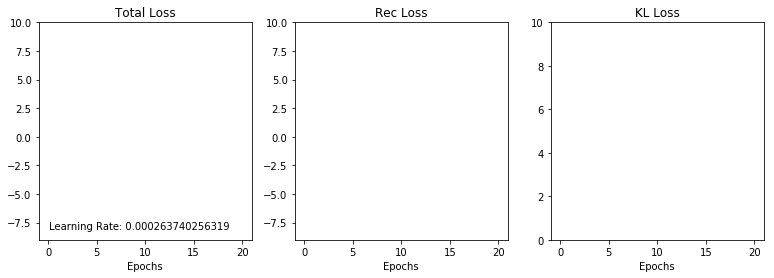

('total loss at epoch: ', 30, ' : ', 343.9947509765625)


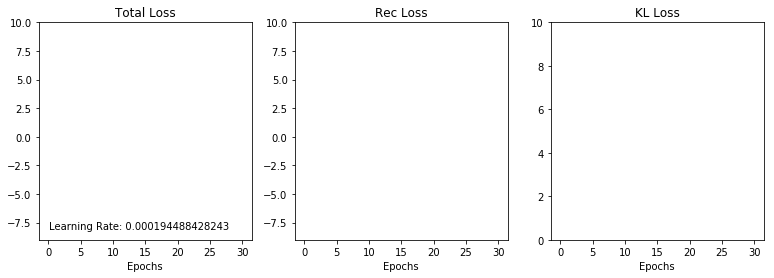

('total loss at epoch: ', 40, ' : ', 219.79123942057291)


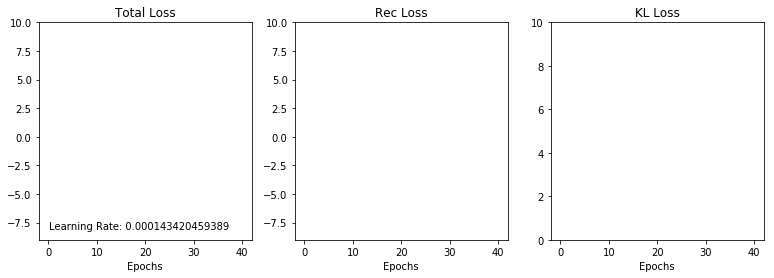

('total loss at epoch: ', 50, ' : ', 147.03743489583334)


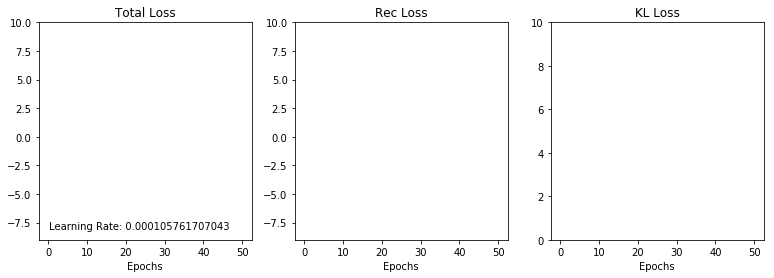

('total loss at epoch: ', 60, ' : ', 110.29847971598308)


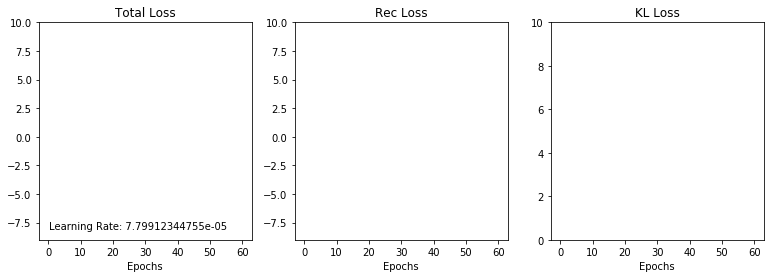

('total loss at epoch: ', 70, ' : ', 91.750490824381515)


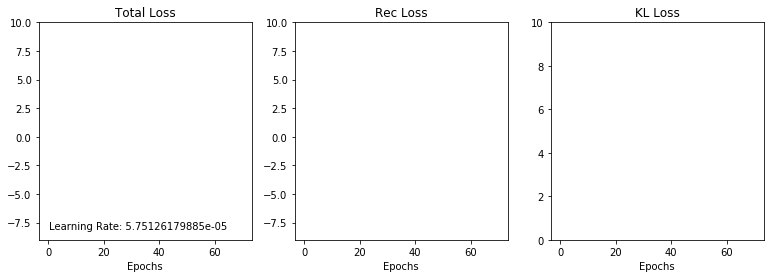

('total loss at epoch: ', 80, ' : ', 73.309814453125)


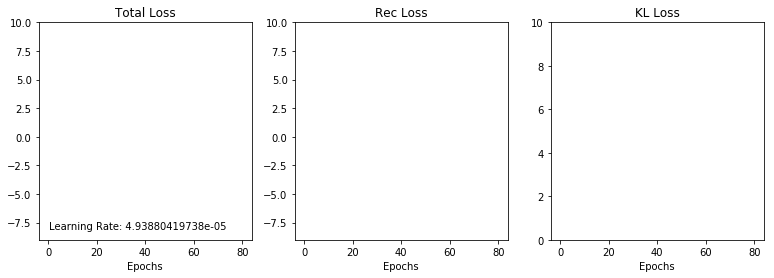

('total loss at epoch: ', 90, ' : ', 68.746780395507812)


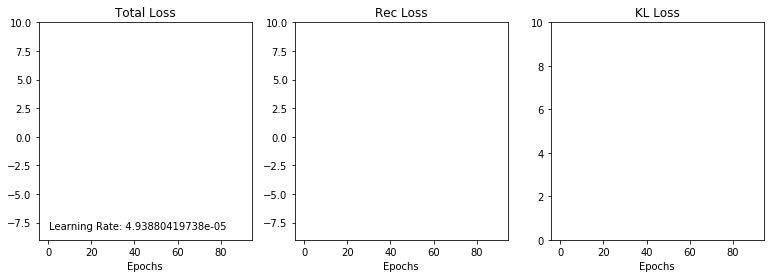

('total loss at epoch: ', 100, ' : ', 57.260016123453774)


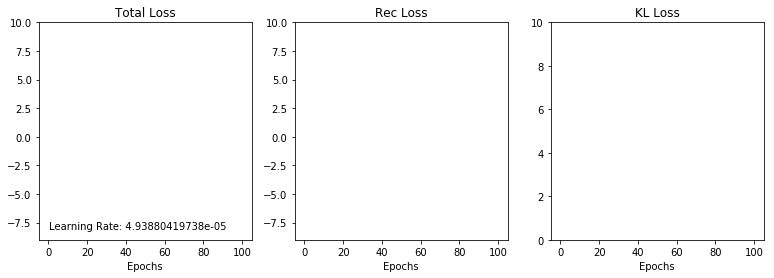

('total loss at epoch: ', 110, ' : ', 46.448350270589195)


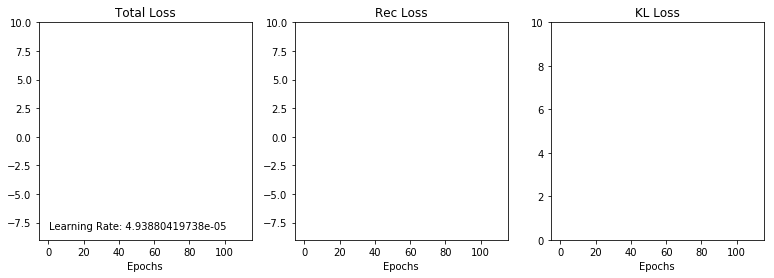

('total loss at epoch: ', 120, ' : ', 45.355725606282554)


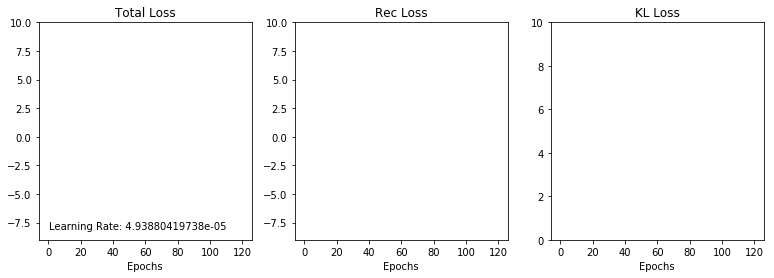

('total loss at epoch: ', 130, ' : ', 39.527011871337891)


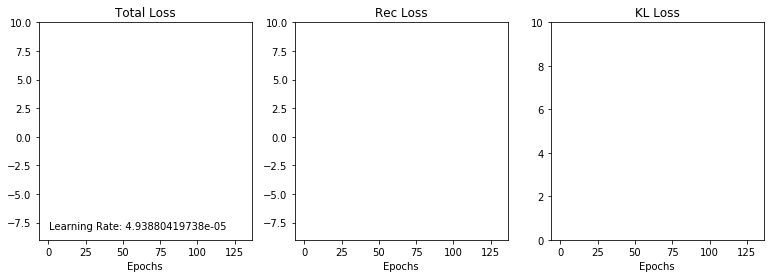

('total loss at epoch: ', 140, ' : ', 50.846458435058594)


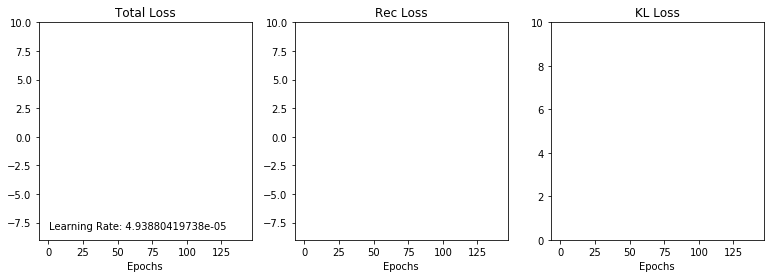

('total loss at epoch: ', 150, ' : ', 39.416136423746742)


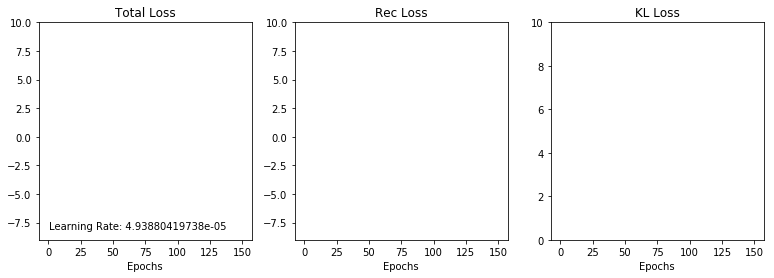

('total loss at epoch: ', 160, ' : ', 37.508099873860679)


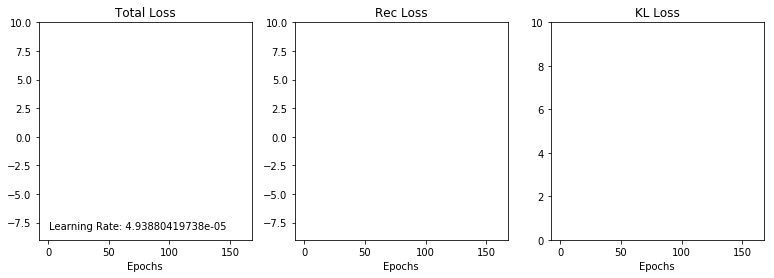

('total loss at epoch: ', 170, ' : ', 33.550001780192055)


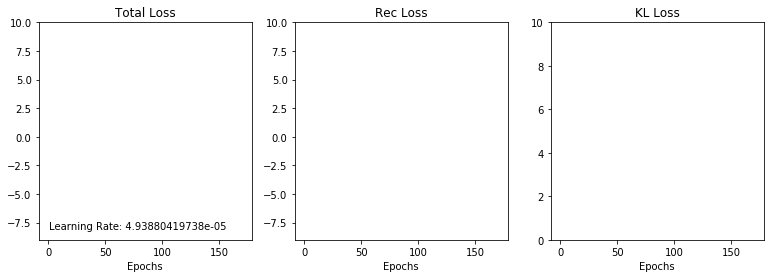

('total loss at epoch: ', 180, ' : ', 26.813351949055988)


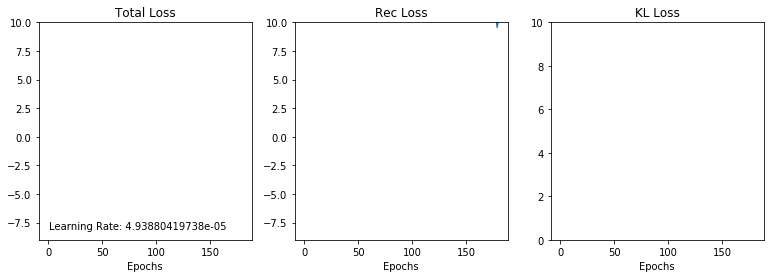

('total loss at epoch: ', 190, ' : ', 26.101324717203777)


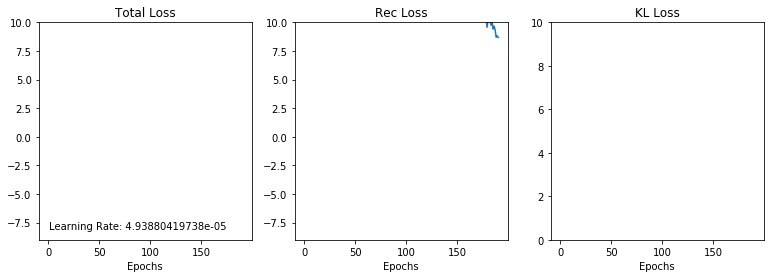

('total loss at epoch: ', 200, ' : ', 23.990740458170574)


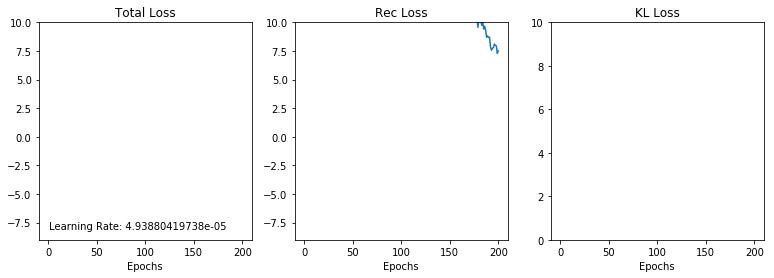

('total loss at epoch: ', 210, ' : ', 22.809811909993488)


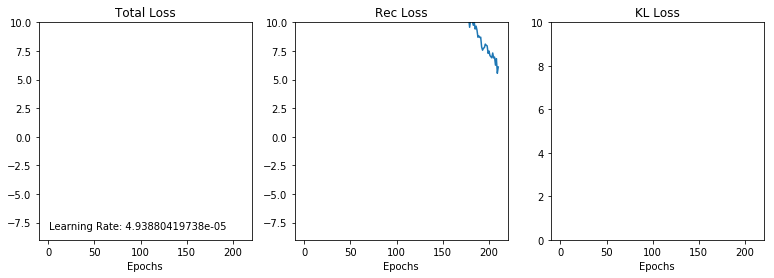

('total loss at epoch: ', 220, ' : ', 21.208728790283203)


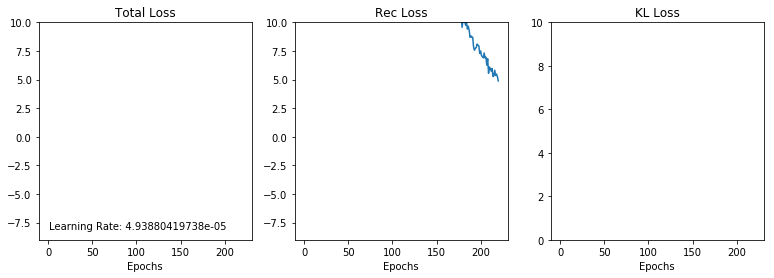

('total loss at epoch: ', 230, ' : ', 20.672669728597004)


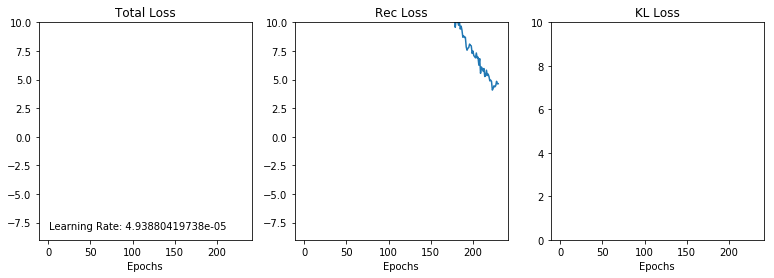

('total loss at epoch: ', 240, ' : ', 18.597970326741535)


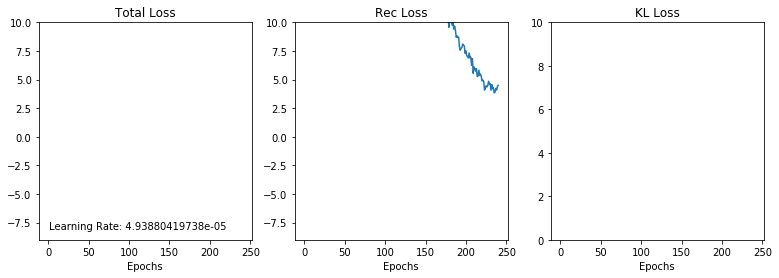

('total loss at epoch: ', 250, ' : ', 19.340113957722981)


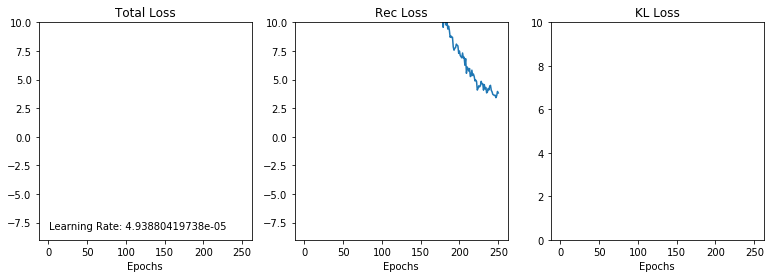

('total loss at epoch: ', 260, ' : ', 18.36195182800293)


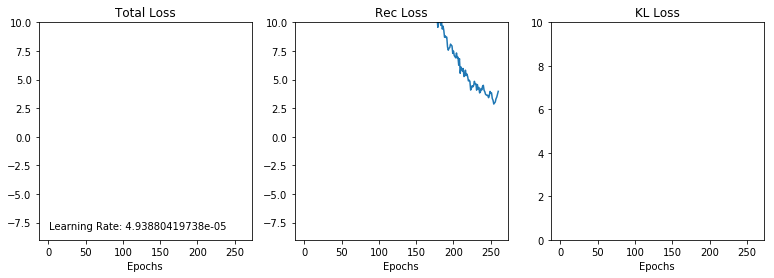

('total loss at epoch: ', 270, ' : ', 17.82001558939616)


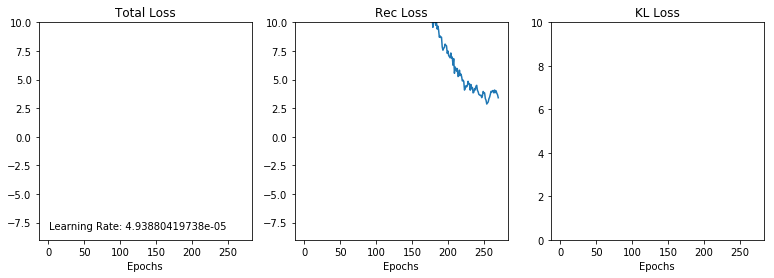

('total loss at epoch: ', 280, ' : ', 15.104679425557455)


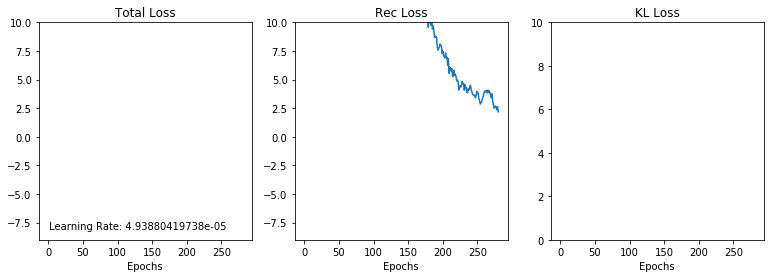

('total loss at epoch: ', 290, ' : ', 15.115104675292969)


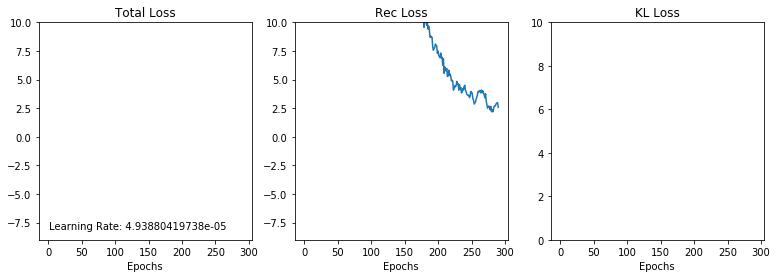

('total loss at epoch: ', 300, ' : ', 14.290974617004395)


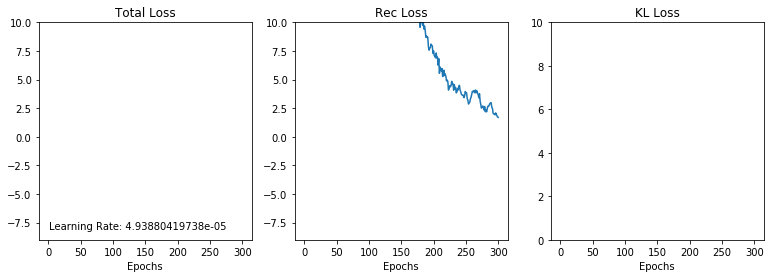

('total loss at epoch: ', 310, ' : ', 13.311885515848795)


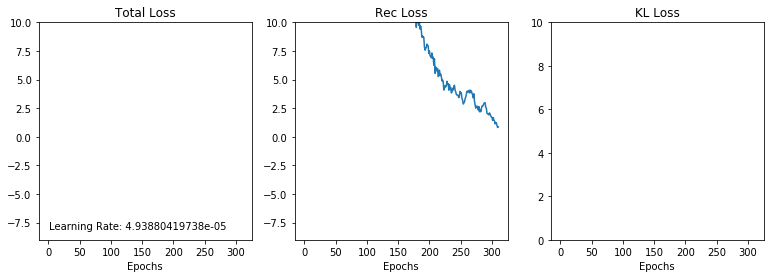

('total loss at epoch: ', 320, ' : ', 13.690107345581055)


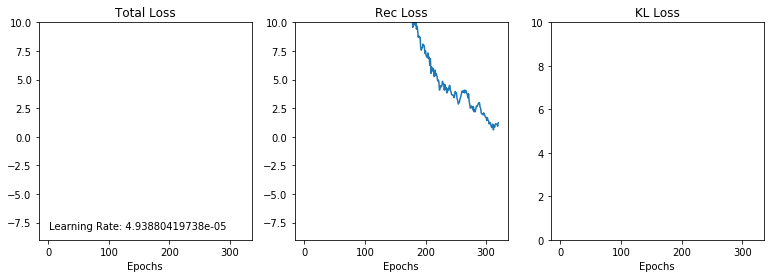

('total loss at epoch: ', 330, ' : ', 13.084437052408854)


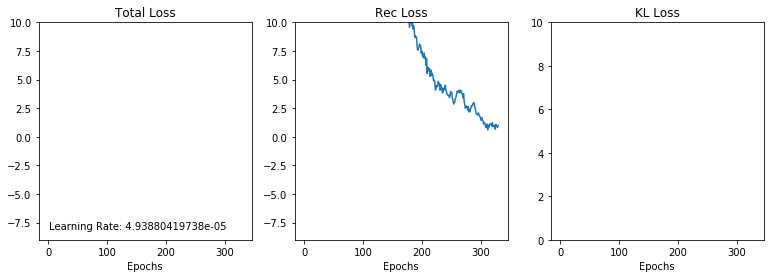

('total loss at epoch: ', 340, ' : ', 12.836772282918295)


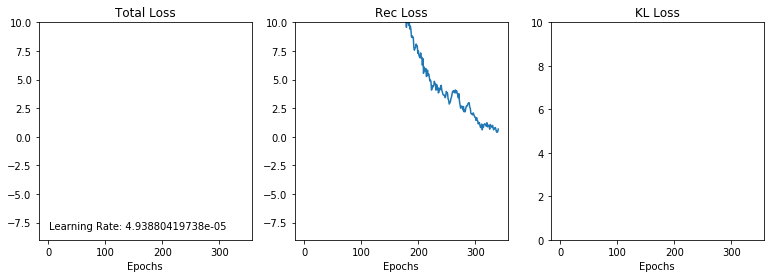

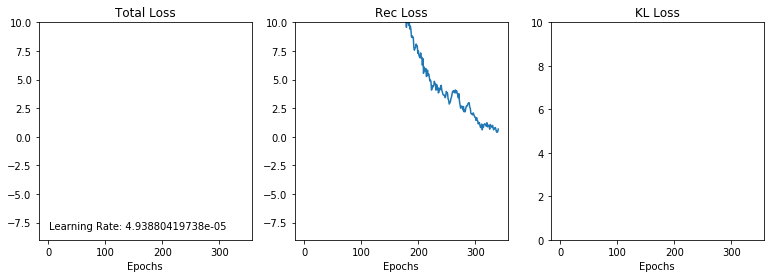

In [3]:
# Define the model
n_obs = 3
n_control = 1
n_latent =  6
n_enc = 10
learning_rate = 0.0005
min_learning_rate = 0.00005
decay_rate = 0.97
m = DVBF(n_obs, n_control, n_latent, n_enc, learning_rate)

# Training parameters
training_epochs = 350
batch_size = 128#16
steps_per_epoch = X.shape[1] / batch_size
display_step = 10

epochs = []
total_loss = []
rec_loss = []
kl_loss = []

# Training cycle
for epoch in range(training_epochs):
    
    # Decay the learning rate
    if learning_rate > min_learning_rate:
        learning_rate *= decay_rate

    # Train one epoch 
    avg_total_loss = .0
    avg_kl_loss = .0
    avg_rec_loss = .0
    for i in range(steps_per_epoch):
        batch_x, batch_u = sample_batch(X, U, batch_size)
        temp_total_loss, temp_kl_loss, temp_rec_loss = m.train(batch_x, batch_u, learning_rate)
        avg_total_loss += temp_total_loss
        avg_kl_loss += temp_kl_loss
        avg_rec_loss += temp_rec_loss
    
    avg_total_loss /= steps_per_epoch
    avg_kl_loss /= steps_per_epoch
    avg_rec_loss /= steps_per_epoch
    
    total_loss.append(avg_total_loss)
    kl_loss.append(avg_kl_loss)
    rec_loss.append(avg_rec_loss)
    epochs.append(epoch)

    # Plot the results
    if epoch % display_step == 0:
                
        plt.close()
        f, axarr = plt.subplots(1, 3, figsize=(13, 4))
        axarr[0].plot(epochs, total_loss)
        axarr[0].set_xlabel('Epochs')
        axarr[0].set_title('Total Loss')
        axarr[0].annotate("Learning Rate: " + str(learning_rate), xy=(0.05, 0.05), xycoords='axes fraction')
        axarr[0].set_ylim(-9.0, 10)
        axarr[1].plot(epochs, rec_loss)
        axarr[1].set_xlabel('Epochs')
        axarr[1].set_title('Rec Loss')
        axarr[1].set_ylim(-9.0, 10)
        axarr[2].plot(epochs, kl_loss)
        axarr[2].set_xlabel('Epochs')
        axarr[2].set_title('KL Loss')
        axarr[2].set_ylim(.0, 10)
        
        print ('total loss at epoch: ', epoch, ' : ',total_loss[-1])

        display.display(plt.gcf())
        display.clear_output(wait=True)

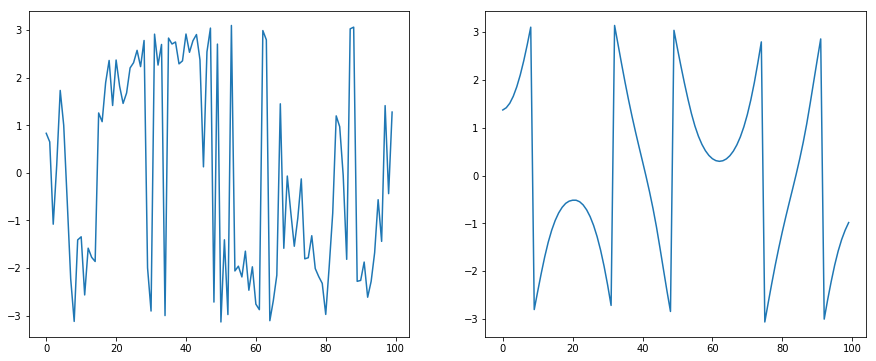

In [5]:
# Get the true trajectory
X_temp, U_temp, R_temp, S_temp = world.get_data_set(episodes=100)
x_obs = m.sess.run((m.gen_x_mean), feed_dict={m.x: X_temp, m.u:U_temp})

# Plot the position and reward of low dim pendulum
e = int(np.random.rand() * 100)
f, axarr = plt.subplots(1, 2, figsize=(15, 6))
axarr[0].plot(np.arctan2(x_obs[:, e, 1], x_obs[:, e, 0]))
axarr[1].plot(np.arctan2(X_temp[:, e, 1], X_temp[:, e, 0]))
plt.show()